In [14]:
from pathlib import Path
import pandas as pd

# 0) Emplacement des fichiers (notebook dans notebooks/ → on remonte à la racine)
ROOT = Path.cwd().parent
SNAPS_DIR = ROOT / "data/raw/velib/snapshots"

files = sorted(SNAPS_DIR.glob("velib_snapshot_*.parquet"))
print(f"{len(files)} fichiers trouvés")

# 1) Lecture et empilement
dfs = [pd.read_parquet(p, engine="pyarrow") for p in files]
df_all = pd.concat(dfs, ignore_index=True)
print("Avant dédup:", df_all.shape)

104 fichiers trouvés
Avant dédup: (155896, 24)


In [15]:
df_all

,ts_utc,ts_local,id,name,lat,lon,capacity,num_bikes_available_norm,num_docks_available_norm,available_mechanical,...,last_reported,fill_rate,station_id,num_bikes_available,numBikesAvailable,num_bikes_available_types,num_docks_available,numDocksAvailable,stationCode,station_opening_hours
0,2025-11-10 11:34:10.985346+00:00,2025-11-10 12:34:10.985346+01:00,213688169,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,4,31,2,...,2025-11-10 10:44:26+00:00,0.114286,213688169,4,4,"[{'ebike': None, 'mechanical': 2.0}, {'ebike':...",31,31,16107,None
1,2025-11-10 11:34:10.985346+00:00,2025-11-10 12:34:10.985346+01:00,19179944124,Hôpital Mondor,48.798922,2.453745,28,10,18,3,...,2025-11-10 10:46:13+00:00,0.357143,19179944124,10,10,"[{'ebike': None, 'mechanical': 3.0}, {'ebike':...",18,18,40001,None
2,2025-11-10 11:34:10.985346+00:00,2025-11-10 12:34:10.985346+01:00,18795078746,Charcot - Benfleet,48.878370,2.440524,28,2,26,0,...,2025-11-10 10:45:32+00:00,0.071429,18795078746,2,2,"[{'ebike': None, 'mechanical': 0.0}, {'ebike':...",26,26,32304,None
3,2025-11-10 11:34:10.985346+00:00,2025-11-10 12:34:10.985346+01:00,36255,Toudouze - Clauzel,48.879296,2.337360,21,2,19,1,...,2025-11-10 10:49:18+00:00,0.095238,36255,2,2,"[{'ebike': None, 'mechanical': 1.0}, {'ebike':...",19,19,9020,None
4,2025-11-10 11:34:10.985346+00:00,2025-11-10 12:34:10.985346+01:00,251039991,Cassini - Denfert-Rochereau,48.837526,2.336035,25,16,7,11,...,2025-11-10 10:49:20+00:00,0.640000,251039991,16,16,"[{'ebike': None, 'mechanical': 11.0}, {'ebike'...",7,7,14111,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155891,2025-11-11 18:54:09.783672+00:00,2025-11-11 19:54:09.783672+01:00,394404659,Gare Saint-Lazare - Cour du Havre,48.875674,2.326560,45,12,31,6,...,2025-11-11 18:52:25+00:00,0.266667,394404659,12,12,"[{'ebike': None, 'mechanical': 6.0}, {'ebike':...",31,31,8002,None
155892,2025-11-11 18:54:09.783672+00:00,2025-11-11 19:54:09.783672+01:00,34742973,Place Balard,48.836396,2.278419,22,18,2,17,...,2025-11-11 18:53:49+00:00,0.818182,34742973,18,18,"[{'ebike': None, 'mechanical': 17.0}, {'ebike'...",2,2,15056,None
155893,2025-11-11 18:54:09.783672+00:00,2025-11-11 19:54:09.783672+01:00,101013666,Bercy - Villot,48.841795,2.376785,33,30,5,26,...,2025-11-11 18:53:29+00:00,0.909091,101013666,30,30,"[{'ebike': None, 'mechanical': 26.0}, {'ebike'...",5,5,12105,None
155894,2025-11-11 18:54:09.783672+00:00,2025-11-11 19:54:09.783672+01:00,315022587,Malesherbes - Place de la Madeleine,48.870406,2.323244,67,43,26,38,...,2025-11-11 18:53:21+00:00,0.641791,315022587,43,43,"[{'ebike': None, 'mechanical': 38.0}, {'ebike'...",26,26,8004,None


In [16]:

df_all= df_all[df_all['last_reported'].astype(str).str.startswith(('2025-11-11','2025-11-10'))]
df_all.shape

(152672, 24)

In [18]:
for c in ("ts_utc", "ts_local", "last_reported"):
    if c in df_all.columns:
        df_all[c] = pd.to_datetime(df_all[c], utc=True, errors="coerce")


# 3) Déduplication
# Variante demandée: clé = (name, last_reported), garder la PLUS RÉCENTE (ts_utc max)
df_name = (
    df_all.sort_values("ts_utc")                # du plus ancien au plus récent
         .drop_duplicates(["name", "last_reported"], keep="last")
         .reset_index(drop=True)
)

print("Après dédup (name+last_reported):", df_name.shape)


Après dédup (name+last_reported): (48537, 24)


/var/folders/90/0y2s7s2s13gg5ppzrhs4cb500000gn/T/ipykernel_88742/492106212.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all[c] = pd.to_datetime(df_all[c], utc=True, errors="coerce")
/var/folders/90/0y2s7s2s13gg5ppzrhs4cb500000gn/T/ipykernel_88742/492106212.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all[c] = pd.to_datetime(df_all[c], utc=True, errors="coerce")
/var/folders/90/0y2s7s2s13gg5ppzrhs4cb500000gn/T/ipykernel_88742/492106212.py:3: SettingWithCopyWarning: 
A value is trying to b

In [19]:
df_name

,ts_utc,ts_local,id,name,lat,lon,capacity,num_bikes_available_norm,num_docks_available_norm,available_mechanical,...,last_reported,fill_rate,station_id,num_bikes_available,numBikesAvailable,num_bikes_available_types,num_docks_available,numDocksAvailable,stationCode,station_opening_hours
0,2025-11-10 11:34:10.985346+00:00,2025-11-10 11:34:10.985346+00:00,213688169,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,4,31,2,...,2025-11-10 10:44:26+00:00,0.114286,213688169,4,4,"[{'ebike': None, 'mechanical': 2.0}, {'ebike':...",31,31,16107,None
1,2025-11-10 11:34:10.985346+00:00,2025-11-10 11:34:10.985346+00:00,1063000561,Gardenat-Lapostol - Velettes,48.873870,2.224185,20,9,10,8,...,2025-11-10 10:43:15+00:00,0.450000,1063000561,9,9,"[{'ebike': None, 'mechanical': 8.0}, {'ebike':...",10,10,21507,None
2,2025-11-10 11:34:10.985346+00:00,2025-11-10 11:34:10.985346+00:00,80419347,Lagny - Auguste Blanqui,48.849226,2.421860,27,13,14,7,...,2025-11-10 10:49:40+00:00,0.481481,80419347,13,13,"[{'ebike': None, 'mechanical': 7.0}, {'ebike':...",14,14,31001,None
3,2025-11-10 11:34:10.985346+00:00,2025-11-10 11:34:10.985346+00:00,1074060095,Lally-Tollendal - Armand Carrel,48.882701,2.374718,28,2,26,1,...,2025-11-10 10:48:14+00:00,0.071429,1074060095,2,2,"[{'ebike': None, 'mechanical': 1.0}, {'ebike':...",26,26,19012,None
4,2025-11-10 11:34:10.985346+00:00,2025-11-10 11:34:10.985346+00:00,54000465,Etienne Marcel - Montorgueil,48.864506,2.346196,28,24,1,16,...,2025-11-10 10:46:59+00:00,0.857143,54000465,24,24,"[{'ebike': None, 'mechanical': 16.0}, {'ebike'...",1,1,2002,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48532,2025-11-11 18:54:09.783672+00:00,2025-11-11 18:54:09.783672+00:00,15387809,Mozart - Jasmin,48.852861,2.268484,62,7,53,2,...,2025-11-11 18:53:52+00:00,0.112903,15387809,7,7,"[{'ebike': None, 'mechanical': 2.0}, {'ebike':...",53,53,16027,None
48533,2025-11-11 18:54:09.783672+00:00,2025-11-11 18:54:09.783672+00:00,15291968,Place de Passy,48.857803,2.277501,15,3,11,2,...,2025-11-11 18:53:18+00:00,0.200000,15291968,3,3,"[{'ebike': None, 'mechanical': 2.0}, {'ebike':...",11,11,16043,None
48534,2025-11-11 18:54:09.783672+00:00,2025-11-11 18:54:09.783672+00:00,210583589,Place Jacques Bonsergent,48.870948,2.361205,33,19,9,17,...,2025-11-11 18:53:36+00:00,0.575758,210583589,19,19,"[{'ebike': None, 'mechanical': 17.0}, {'ebike'...",9,9,10010,None
48535,2025-11-11 18:54:09.783672+00:00,2025-11-11 18:54:09.783672+00:00,54000618,Pyrénées - Maraîchers,48.857140,2.404351,33,4,28,1,...,2025-11-11 18:47:24+00:00,0.121212,54000618,4,4,"[{'ebike': None, 'mechanical': 1.0}, {'ebike':...",28,28,20016,None


In [20]:
obs_par_name = (
    df_name.groupby("name")
           .size()
           .reset_index(name="n_obs")
)

print(obs_par_name)


                                      name  n_obs
0            11 Novembre 1918 - 8 Mai 1945     32
1                  18 juin 1940 - Buzenval     36
2             8 Mai 1945 - 10 Juillet 1940     33
3        Abbeville - Faubourg Poissonnière     32
4                    Abbé Carton - Plantes     32
...                                    ...    ...
1460            Youri Gagarine - Karl Marx     32
1461         Yves Farges - Route d'Enghien     33
1462                    ZAC des Louvresses     33
1463  Édouard Vaillant - Place Jean Jaurès     33
1464                       Île de la Jatte     33

[1465 rows x 2 columns]


In [22]:
obs_par_name.describe()

,n_obs
count,1465.000000
mean,33.131058
std,1.938050
min,30.000000
25%,32.000000
50%,33.000000
75%,34.000000
max,65.000000


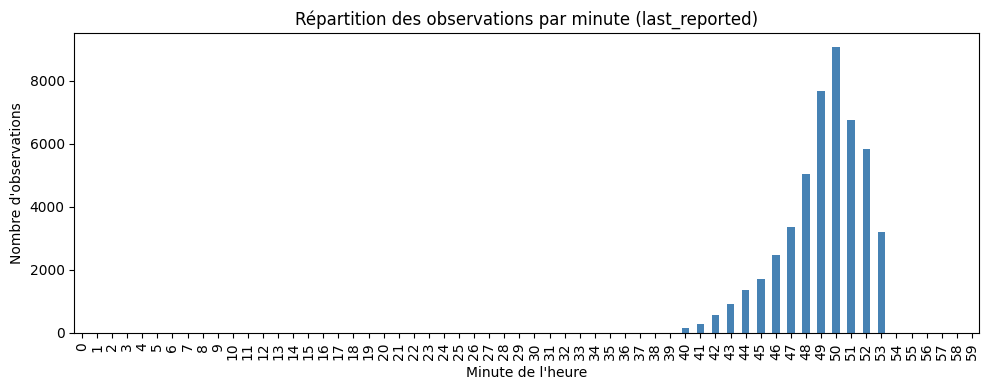

In [24]:
import matplotlib.pyplot as plt

# Nombre d'observations pour chaque minute (0–59)
minute_counts = (
    df_name["last_reported"]
    .dt.minute
    .value_counts()
    .reindex(range(60), fill_value=0)
    .sort_index()
)

# Histogramme où l’axe X est la minute de l’heure
fig, ax = plt.subplots(figsize=(10, 4))
minute_counts.plot(kind="bar", ax=ax, color="steelblue")
ax.set_xlabel("Minute de l'heure")
ax.set_ylabel("Nombre d'observations")
ax.set_title("Répartition des observations par minute (last_reported)")
plt.tight_layout()
plt.show()


In [42]:
from pathlib import Path
import pandas as pd

ROOT = Path.cwd().parent                    # …/Velib-analytics

# Différents Snap distant 
snap = ROOT / "data/raw/velib/snapshots/velib_snapshot_20251110_184031.parquet"
snap1 = ROOT / "data/raw/velib/snapshots/velib_snapshot_20251110_192405.parquet"
snap2= ROOT / "data/raw/velib/snapshots/velib_snapshot_20251110_203448.parquet"

#print("Fichier existe ?", snap.exists(), "\n", snap)

df = pd.read_parquet(snap, engine="pyarrow")
df1 = pd.read_parquet(snap1, engine="pyarrow")
df2 = pd.read_parquet(snap2, engine="pyarrow")
df.head()

,ts_utc,ts_local,id,name,lat,lon,capacity,num_bikes_available_norm,num_docks_available_norm,available_mechanical,...,last_reported,fill_rate,station_id,num_bikes_available,numBikesAvailable,num_bikes_available_types,num_docks_available,numDocksAvailable,stationCode,station_opening_hours
0,2025-11-10 18:40:31.703254+00:00,2025-11-10 19:40:31.703254+01:00,213688169,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,4,31,2,...,2025-11-10 17:47:50+00:00,0.114286,213688169,4,4,"[{'ebike': None, 'mechanical': 2.0}, {'ebike':...",31,31,16107,None
1,2025-11-10 18:40:31.703254+00:00,2025-11-10 19:40:31.703254+01:00,19179944124,Hôpital Mondor,48.798922,2.453745,28,5,23,1,...,2025-11-10 17:48:23+00:00,0.178571,19179944124,5,5,"[{'ebike': None, 'mechanical': 1.0}, {'ebike':...",23,23,40001,None
2,2025-11-10 18:40:31.703254+00:00,2025-11-10 19:40:31.703254+01:00,18795078746,Charcot - Benfleet,48.878370,2.440524,28,3,25,0,...,2025-11-10 17:48:42+00:00,0.107143,18795078746,3,3,"[{'ebike': None, 'mechanical': 0.0}, {'ebike':...",25,25,32304,None
3,2025-11-10 18:40:31.703254+00:00,2025-11-10 19:40:31.703254+01:00,36255,Toudouze - Clauzel,48.879296,2.337360,21,1,20,0,...,2025-11-10 17:49:57+00:00,0.047619,36255,1,1,"[{'ebike': None, 'mechanical': 0.0}, {'ebike':...",20,20,9020,None
4,2025-11-10 18:40:31.703254+00:00,2025-11-10 19:40:31.703254+01:00,251039991,Cassini - Denfert-Rochereau,48.837526,2.336035,25,2,21,2,...,2025-11-10 17:48:50+00:00,0.080000,251039991,2,2,"[{'ebike': None, 'mechanical': 2.0}, {'ebike':...",21,21,14111,None


In [43]:
df1.head()

,ts_utc,ts_local,id,name,lat,lon,capacity,num_bikes_available_norm,num_docks_available_norm,available_mechanical,...,last_reported,fill_rate,station_id,num_bikes_available,numBikesAvailable,num_bikes_available_types,num_docks_available,numDocksAvailable,stationCode,station_opening_hours
0,2025-11-10 19:24:05.276628+00:00,2025-11-10 20:24:05.276628+01:00,213688169,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,6,29,3,...,2025-11-10 18:48:27+00:00,0.171429,213688169,6,6,"[{'ebike': None, 'mechanical': 3.0}, {'ebike':...",29,29,16107,None
1,2025-11-10 19:24:05.276628+00:00,2025-11-10 20:24:05.276628+01:00,19179944124,Hôpital Mondor,48.798922,2.453745,28,4,24,1,...,2025-11-10 18:50:13+00:00,0.142857,19179944124,4,4,"[{'ebike': None, 'mechanical': 1.0}, {'ebike':...",24,24,40001,None
2,2025-11-10 19:24:05.276628+00:00,2025-11-10 20:24:05.276628+01:00,18795078746,Charcot - Benfleet,48.878370,2.440524,28,3,25,0,...,2025-11-10 18:49:16+00:00,0.107143,18795078746,3,3,"[{'ebike': None, 'mechanical': 0.0}, {'ebike':...",25,25,32304,None
3,2025-11-10 19:24:05.276628+00:00,2025-11-10 20:24:05.276628+01:00,36255,Toudouze - Clauzel,48.879296,2.337360,21,7,13,4,...,2025-11-10 18:50:48+00:00,0.333333,36255,7,7,"[{'ebike': None, 'mechanical': 4.0}, {'ebike':...",13,13,9020,None
4,2025-11-10 19:24:05.276628+00:00,2025-11-10 20:24:05.276628+01:00,251039991,Cassini - Denfert-Rochereau,48.837526,2.336035,25,3,19,0,...,2025-11-10 18:44:55+00:00,0.120000,251039991,3,3,"[{'ebike': None, 'mechanical': 0.0}, {'ebike':...",19,19,14111,None


In [44]:
df2.head()

,ts_utc,ts_local,id,name,lat,lon,capacity,num_bikes_available_norm,num_docks_available_norm,available_mechanical,...,last_reported,fill_rate,station_id,num_bikes_available,numBikesAvailable,num_bikes_available_types,num_docks_available,numDocksAvailable,stationCode,station_opening_hours
0,2025-11-10 20:34:48.162975+00:00,2025-11-10 21:34:48.162975+01:00,213688169,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,6,29,1,...,2025-11-10 19:49:08+00:00,0.171429,213688169,6,6,"[{'ebike': None, 'mechanical': 1.0}, {'ebike':...",29,29,16107,None
1,2025-11-10 20:34:48.162975+00:00,2025-11-10 21:34:48.162975+01:00,19179944124,Hôpital Mondor,48.798922,2.453745,28,3,25,1,...,2025-11-10 19:50:35+00:00,0.107143,19179944124,3,3,"[{'ebike': None, 'mechanical': 1.0}, {'ebike':...",25,25,40001,None
2,2025-11-10 20:34:48.162975+00:00,2025-11-10 21:34:48.162975+01:00,18795078746,Charcot - Benfleet,48.878370,2.440524,28,3,25,0,...,2025-11-10 19:49:54+00:00,0.107143,18795078746,3,3,"[{'ebike': None, 'mechanical': 0.0}, {'ebike':...",25,25,32304,None
3,2025-11-10 20:34:48.162975+00:00,2025-11-10 21:34:48.162975+01:00,36255,Toudouze - Clauzel,48.879296,2.337360,21,7,13,4,...,2025-11-10 19:50:07+00:00,0.333333,36255,7,7,"[{'ebike': None, 'mechanical': 4.0}, {'ebike':...",13,13,9020,None
4,2025-11-10 20:34:48.162975+00:00,2025-11-10 21:34:48.162975+01:00,251039991,Cassini - Denfert-Rochereau,48.837526,2.336035,25,5,17,1,...,2025-11-10 19:45:31+00:00,0.200000,251039991,5,5,"[{'ebike': None, 'mechanical': 1.0}, {'ebike':...",17,17,14111,None


In [45]:
df.columns 

Index(['ts_utc', 'ts_local', 'id', 'name', 'lat', 'lon', 'capacity',
       'num_bikes_available_norm', 'num_docks_available_norm',
       'available_mechanical', 'available_ebike', 'is_installed', 'is_renting',
       'is_returning', 'last_reported', 'fill_rate', 'station_id',
       'num_bikes_available', 'numBikesAvailable', 'num_bikes_available_types',
       'num_docks_available', 'numDocksAvailable', 'stationCode',
       'station_opening_hours'],
      dtype='object')

In [46]:
print("min :", df["last_reported"].min())
print("max :", df["last_reported"].max())


min : 2018-03-16 12:30:20+00:00
max : 2025-11-10 17:50:53+00:00


In [47]:
masque = df["last_reported"].astype(str).str.startswith("2025-11-10")
filtre = df.loc[masque, "last_reported"]

print("min :", filtre.min())
print("max :", filtre.max())

min : 2025-11-10 17:40:57+00:00
max : 2025-11-10 17:50:53+00:00


In [48]:
masque1 = df1["last_reported"].astype(str).str.startswith("2025-11-10")
filtre1 = df1.loc[masque1, "last_reported"]

print("min :", filtre1.min())
print("max :", filtre1.max())

min : 2025-11-10 18:32:51+00:00
max : 2025-11-10 18:50:56+00:00


In [49]:
masque2 = df2["last_reported"].astype(str).str.startswith("2025-11-10")
filtre2 = df2.loc[masque2, "last_reported"]

print("min :", filtre2.min())
print("max :", filtre2.max())

min : 2025-11-10 19:40:55+00:00
max : 2025-11-10 19:51:08+00:00


In [15]:
len(filtre)

1468